# MTA Traffic Forecasting
#### Justin Morgan & Khyatee Desai
This notebook includes the data collection, storage, and cleaning process. The data is sourced from the [MTA turnstile data archive](http://web.mta.info/developers/turnstile.html), which all turnstile data from all NYC subway stations in comma delineated text files, segmented by week.
# Part 1: Web Scrape MTA Data
The data is iteratively scraped from the webpage using BeautifulSoup, and the text files are currently stored locally within a "data" folder.
<br><br>
Future steps will involve storing this data within an S3 bucket in the AWS cloud for faster storage & retrieval.

In [31]:
# import necessary packages
import pandas as pd
import numpy as np
import os
import requests
import urllib.request
import time
from timeit import default_timer as timer
import humanfriendly
from bs4 import BeautifulSoup
from datetime import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sodapy import Socrata
import geopandas as gpd
from shapely.geometry import shape

# import api token
from src import *

### Get MTA turnstile data from publicly available website

In [286]:
url_root = r'http://web.mta.info/developers/' # set root url
# path = r'/Users/justinwilliams/projects/mta_turnstile/data/' # commented this out and changed it below to just save to "./data/" folder so it works for both of us - k
starttime = timer() # start timer to time process

req = requests.get(url_root + 'turnstile.html') # send request
soup = BeautifulSoup(req.content, 'html.parser') # parse html and save to bs4 object
weekly_data = soup.find(class_='span-84 last') # find class_ where file links are locatedb

## This way took much longer so used urllib.request.urlretrieve
# for file in weekly_data.findAll('a'):
#     print('Saving file turnstile ' + str(file)[39:49])
#     datafile = requests.get(url_root + str(file)[9:49])
#     with open(path + str(file)[39:49], 'w') as outf:
#         for line in datafile.text:
#             outf.writelines(line)
#     time.sleep(1)

# endtime = timer()
# print('Completed in ' + humanfriendly.format_timespan(endtime-starttime))

counter = 1
while counter <= 5:
    for one_a_tag in weekly_data.findAll('a')[:10]: #just using first 10 files for now
        file = one_a_tag['href']
        datafile = url_root + file
        urllib.request.urlretrieve(datafile, './data/' + datafile[datafile.find('/turnstile_')+1:])
        time.sleep(1)
        counter += 1
        print('Saving file turnstile ' + str(one_a_tag)[39:49])
    
endtime = timer()
print('Completed in ' + humanfriendly.format_timespan(endtime-starttime))

Saving file turnstile 210313.txt
Saving file turnstile 210306.txt
Saving file turnstile 210227.txt
Saving file turnstile 210220.txt
Saving file turnstile 210213.txt
Saving file turnstile 210206.txt
Saving file turnstile 210130.txt
Saving file turnstile 210123.txt
Saving file turnstile 210116.txt
Saving file turnstile 210109.txt
Completed in 37.65 seconds


Took __47 minutes and 17.79 seconds__ to download all files, also folder size is __12.05GB__

Maybe there is a better way to do this?

# (Prob won't have to do this if Socrata API works)
## Web Scrape Station Coordinates from Wikipedia
Station coordinates will be utilzed to visiualize data geospatially.
- <a href="https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Manhattan" target=blank> Manhattan</a>
- <a href="https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Brooklyn" target=blank> Brooklyn</a>
- <a href="https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Queens" target=blank> Queens</a>
- <a href="https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_the_Bronx" target=blank> Bronx</a>
- <a href="https://en.wikipedia.org/wiki/Staten_Island_Railway" target=blank> Staten Island</a>

Coordinates are on the upper right hand side of each stations specific page...these can be navigated too through web scraping...prob will have to write a slightly different code module for each borough. lol

## Use Socrata API from OpenData to download geospatial files

In [36]:
# set client request for Socrata API
client = Socrata("data.cityofnewyork.us",app_token)

# make request using API endpoint
results = client.get("kk4q-3rt2")

# create GeoDataFrame out of request
gdf = gpd.GeoDataFrame(results)

In [52]:
# check info
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   url       473 non-null    object  
 1   objectid  473 non-null    object  
 2   name      473 non-null    object  
 3   geometry  473 non-null    geometry
 4   line      473 non-null    object  
 5   notes     473 non-null    object  
dtypes: geometry(1), object(5)
memory usage: 22.3+ KB


### Set the Geometry

Geometry column needs to be set. 

<u>Steps to complete:</u>

- use the `shapely` package to convert `the_geom` column from a geojson and return an independent geometry with coordinates.
- set the geometry column to the transformed `the_geom` column
- rename the `the_geom` column to `geometry`
- check dtypes to ensure `geometry` column is properly formatted

In [38]:
# apply shape to geojson column to convert to geom
gdf['the_geom'] = gdf['the_geom'].apply(shape)

In [40]:
# set geometry to the geom
gdf.set_geometry('the_geom', inplace=True)

In [41]:
# rename geometry column to geometry
gdf.rename_geometry('geometry', inplace=True)

In [42]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   url       473 non-null    object  
 1   objectid  473 non-null    object  
 2   name      473 non-null    object  
 3   geometry  473 non-null    geometry
 4   line      473 non-null    object  
 5   notes     473 non-null    object  
dtypes: geometry(1), object(5)
memory usage: 22.3+ KB


### Set the coordinate reference system (CRS)

Since we are dealing soley with NYC, need to transform the GDF to New York State Plane EPSG 2263 CRS. This is typically used for projections of NYC, because it is the local coordinate system that best balances it's size and shape. 

<u>Steps to complete:</u>

- use the .to_crs() method to transform the GDF to EPSG 2263
- use .crs() method to verify it was correctly set

In [47]:
# set crs to NAD
gdf.set_crs(2263, inplace=True)

,url,objectid,name,geometry,line,notes
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99107 40.73005),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019 40.71880),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98385 40.76173),1-2,"1-all times, 2-nights"
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97500 40.68086),2-3-4,"4-nights, 3-all other times, 2-all times"
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89489 40.66471),3-4,"4-nights, 3-all other times"
...,...,...,...,...,...,...
468,http://web.mta.info/nyct/service/,469,Coney Island - Stillwell Av,POINT (-73.98124 40.57728),D-F-N-Q,"D,F,N,Q-all times"
469,http://web.mta.info/nyct/service/,470,34th St - Hudson Yards,POINT (-74.00220 40.75545),7-7 Express,"7-all times, 7 Express-rush hours AM westbound..."
470,http://web.mta.info/nyct/service/,641,72nd St,POINT (-73.95836 40.76880),Q,Q-all times
471,http://web.mta.info/nyct/service/,642,86th St,POINT (-73.95177 40.77786),Q,Q-all times


In [49]:
# check set crs was implemented correctly
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Export gdf

In [51]:
# export shapefile for import into data analysis notebook
gdf.to_file('./shp/gdf.shp', driver='ESRI Shapefile')

## Concatenate Files
Concatenate each data file into a Pandas dataframe

In [287]:
# create main df using first file in the folder
for filename in os.listdir("./data/")[:1]:
    df = pd.read_csv("./data/"+filename)

# iterate over remaining files in the folder and concat them to main df
for filename in os.listdir("./data/")[1:]:
    df = pd.concat([df,pd.read_csv("./data/"+filename)])

In [288]:
df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,03:00:00,REGULAR,7524539,2564693
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,07:00:00,REGULAR,7524543,2564703
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,11:00:00,REGULAR,7524566,2564755
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,15:00:00,RECOVR AUD,7524643,2564793
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,19:00:00,REGULAR,7524739,2564811
...,...,...,...,...,...,...,...,...,...,...,...
209039,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/19/2021,04:00:00,REGULAR,5554,544
209040,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/19/2021,08:00:00,REGULAR,5554,544
209041,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/19/2021,12:00:00,REGULAR,5554,544
209042,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/19/2021,16:00:00,REGULAR,5554,544


# Part 2: Data Cleaning
The below cells entail cleaning, reformatting, and aggregating the data

### Field Descriptions <br>
http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

`C/A      = Control Area (A002)`<br>
`UNIT     = Remote Unit for a station (R051)`<br>
`SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)`<br>
`STATION  = Represents the station name the device is located at`<br>
`LINENAME = Represents all train lines that can be boarded at this station
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.`<br>
`DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   `<br>
`DATE     = Represents the date (MM-DD-YY)`<br>
`TIME     = Represents the time (hh:mm:ss) for a scheduled audit event`<br>
`DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)`<br>
        `1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.`<br>
        `2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.`<br>
`ENTRIES  = The comulative entry register value for a device`<br>
`EXIST    = The cumulative exit register value for a device`<br>


## Reformat Data Types
Convert strings to DateTime format

In [289]:
df.DATE = pd.to_datetime(df['DATE'])

### Change Time Column to Timestamp Object
*Commented out for now because probably not going to use timestamps, just focusing on date*

In [290]:
# df.TIME = pd.to_datetime(df['TIME'])
# df.TIME.apply(lambda x: dt.timestamp(x))

In [291]:
df.dtypes

C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DATE                                                                    datetime64[ns]
TIME                                                                            object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
dtype: object

### Inspect a specific station & date

In [292]:
df[(df.STATION == 'HALSEY ST') & (df.DATE.astype(str)=='2021-02-15')].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
36293,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,03:00:00,REGULAR,5897529,3008491
36294,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,07:00:00,REGULAR,5897606,3008499
36295,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,11:00:00,REGULAR,5897771,3008564
36296,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,15:00:00,REGULAR,5897864,3008636
36297,H028,R266,00-00-00,HALSEY ST,L,BMT,2021-02-15,19:00:00,REGULAR,5897921,3008755


## Derive Daily Entries
Entries and Exits are currently listed cumulatively. The below process groups the dataframe by station, date, SCP, UNIT, and C/A on Max and Min, then subtracts the two to find the number of turnstile entries per day at each station.

*....not really sure what SCP, UNIT, and C/A are but i think they might indicate an individual tracker device at a station for each turnstile? idkidk*

In [293]:
# min gives us cumulative entries at the beginning of each day
df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].min()

ENTRIES
STATION   DATE       SCP      UNIT C/A            
1 AV      2021-01-02 00-00-00 R248 H007   15512620
                     00-00-01 R248 H007   61216301
                     00-03-00 R248 H007  370876227
                     00-03-01 R248 H007    2614082
                     00-03-02 R248 H007    6655790
...                                            ...
ZEREGA AV 2021-03-12 00-00-01 R326 R419     227376
                     00-03-00 R326 R419    1142551
                     00-03-01 R326 R419    1218309
                     00-05-00 R326 R419        232
                     00-05-01 R326 R419         39

[349092 rows x 1 columns]

In [294]:
# max gives us cumulative entries at the end of each day
df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].max()

ENTRIES
STATION   DATE       SCP      UNIT C/A            
1 AV      2021-01-02 00-00-00 R248 H007   15512810
                     00-00-01 R248 H007   61216603
                     00-03-00 R248 H007  370876269
                     00-03-01 R248 H007    2614120
                     00-03-02 R248 H007    6655885
...                                            ...
ZEREGA AV 2021-03-12 00-00-01 R326 R419     227473
                     00-03-00 R326 R419    1142796
                     00-03-01 R326 R419    1218850
                     00-05-00 R326 R419        232
                     00-05-01 R326 R419         39

[349092 rows x 1 columns]

In [295]:
# subtract min from max to get number of entries each day
grouped = df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].max()- df.groupby(['STATION','DATE','SCP','UNIT','C/A'])[['ENTRIES']].min()
grouped


ENTRIES
STATION   DATE       SCP      UNIT C/A          
1 AV      2021-01-02 00-00-00 R248 H007      190
                     00-00-01 R248 H007      302
                     00-03-00 R248 H007       42
                     00-03-01 R248 H007       38
                     00-03-02 R248 H007       95
...                                          ...
ZEREGA AV 2021-03-12 00-00-01 R326 R419       97
                     00-03-00 R326 R419      245
                     00-03-01 R326 R419      541
                     00-05-00 R326 R419        0
                     00-05-01 R326 R419        0

[349092 rows x 1 columns]

### Sum Counts from all Devices

In [296]:
# sum up all of the devices at a station to get total daily entries
grouped_entries = grouped.groupby(['STATION', 'DATE']).sum()
grouped_entries

ENTRIES
STATION   DATE               
1 AV      2021-01-02     3559
          2021-01-03     2415
          2021-01-04     5193
          2021-01-05     5333
          2021-01-06     5468
...                       ...
ZEREGA AV 2021-03-08      918
          2021-03-09      979
          2021-03-10      976
          2021-03-11     1051
          2021-03-12     1015

[26449 rows x 1 columns]

### Pivot Table

In [297]:
# pivot the dataframe so date on the columns
entries_df = grouped_entries.pivot_table(index='DATE', columns='STATION')
entries_df.columns = entries_df.columns.droplevel(0) # drop unnecessary multindex level
entries_df.head()

STATION,1 AV,103 ST,103 ST-CORONA,104 ST,110 ST,111 ST,116 ST,116 ST-COLUMBIA,121 ST,125 ST,...,WHITEHALL S-FRY,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,WORLD TRADE CTR,WTC-CORTLANDT,YORK ST,ZEREGA AV
DATE,,,,,,,,,,,,,,,,,,,,,
2021-01-02,3559.0,4694.0,6158.0,979.0,2115.0,4661.0,5677.0,693.0,550.0,13679.0,...,1824.0,466.0,973.0,1074.0,5682.0,1816.0,161.0,1594.0,1.0,472.0
2021-01-03,2415.0,3278.0,4571.0,647.0,1522.0,3387.0,3994.0,455.0,401.0,9582.0,...,981.0,337.0,724.0,842.0,3784.0,1130.0,59.0,648.0,2.0,354.0
2021-01-04,5193.0,7801.0,9253.0,1800.0,3378.0,7114.0,8669.0,1921.0,903.0,21790.0,...,2950.0,788.0,1429.0,2552.0,73887.0,2780.0,2309.0,1546.0,2129.0,918.0
2021-01-05,5333.0,8251.0,9794.0,1795.0,3630.0,7692.0,9119.0,1936.0,946.0,22314.0,...,2880.0,819.0,1513.0,2677.0,8911.0,2926.0,2395.0,1492.0,2153.0,956.0
2021-01-06,5468.0,8467.0,9972.0,1832.0,3850.0,7622.0,9131.0,2021.0,938.0,21924.0,...,2404.0,841.0,1528.0,2609.0,9127.0,2840.0,2403.0,1560.0,2202.0,932.0


## Check for Nulls
Will impute all nulls in the next step (outliers)

In [298]:
entries_df.columns[entries_df.isnull().sum().values>0]

Index(['116 ST-COLUMBIA', '191 ST', '207 ST', '215 ST', 'BAY RIDGE-95 ST',
       'MARBLE HILL-225', 'SUTTER AV-RUTLD'],
      dtype='object', name='STATION')

In [299]:
entries_df['BAY RIDGE-95 ST']

DATE
2021-01-02     997.0
2021-01-03     756.0
2021-01-04    1910.0
2021-01-05    1944.0
2021-01-06    2042.0
               ...  
2021-03-08    2027.0
2021-03-09    2212.0
2021-03-10    2207.0
2021-03-11    2191.0
2021-03-12    2089.0
Name: BAY RIDGE-95 ST, Length: 70, dtype: float64

## Impute Outliers
This process identities outliers (larger than 5 standard deviations from the mean,) converts them to null, then interpolates them using the surrounding data points.
### Inspect Penn Station Outlier

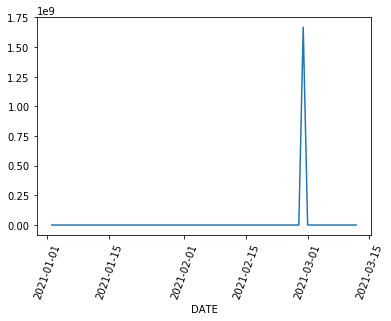

In [300]:
sns.lineplot(entries_df["34 ST-PENN STA"].index, entries_df["34 ST-PENN STA"].values);
plt.xticks(rotation=70);

In [301]:
# replace all outliers with null
for col in entries_df.columns:
    mean = entries_df[col].mean()
    std_5 = entries_df[col].std() *5
    entries_df[col] = np.where(entries_df[col] > mean + std_5, np.nan, entries_df[col])


In [302]:
# inspect all nulls that were added as outliers
entries_df.isnull().sum()

STATION
1 AV               1
103 ST             0
103 ST-CORONA      0
104 ST             0
110 ST             0
                  ..
WOODLAWN           0
WORLD TRADE CTR    1
WTC-CORTLANDT      0
YORK ST            0
ZEREGA AV          0
Length: 378, dtype: int64

### Interpolate

In [303]:
# replace null values with surrounding data points
for col in entries_df.columns:
    entries_df[col] = entries_df[col].interpolate(method='time',limit_direction='both')

In [304]:
# confirm nulls have been replaced
entries_df.isnull().sum().any()

False

### Inspect Penn Station after outliers imputed

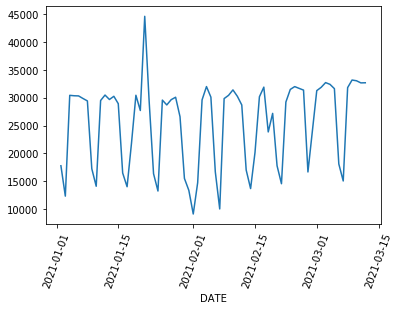

In [305]:
sns.lineplot(entries_df["34 ST-PENN STA"].index, entries_df["34 ST-PENN STA"].values);
plt.xticks(rotation=70);

### Pickle Cleaned Data

In [306]:
# entries_df.to_pickle("./pickled/cleaned_data")